<a href="https://colab.research.google.com/github/EdioHub/ArtMl-Autoencoder-Som/blob/main/ArtMLEncodeSom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inicialização do google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
! ls

gdrive	sample_data


In [7]:
%cd drive/MyDrive/Projetos git/07-Artml_Som/nga_dataset

[Errno 2] No such file or directory: 'drive/MyDrive/Projetos git/07-Artml_Som/nga_dataset'
/content


# Importação das bibliotecas

In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import requests
import os

from sklearn.model_selection import train_test_split
from PIL import Image

# Definição dos hiperparâmetros

In [9]:
SEED = 13

IMAGE_GRID_WIDTH = 5

# Hiperparâmetros do autoencoder
CONVOLUTIONAL_BLOCKS = 3
BASE_FILTER_SIZE = 12
COMPRESSION_SIZE = 32
KERNEL_SIZE = 4

PRE_TRAINED_CHECKPOINT_PATH = './pretrained-autoencoder.ckpt'
CHECKPOINT_PATH = './autoencoder.ckpt'
MAX_EPOCHS = 5

# Hiperparâmetros do SOM
STEP_COUNT = 3000
NODE_COUNT = 5

SIGMA_DECAY_RATE = 0.03
INITIAL_SIGMA = 1e-3

ETA_DECAY_RATE = 0.1
INITIAL_ETA = 1e-4

# Download das imagens do dataset

In [10]:
df = pd.read_csv("https://raw.githubusercontent.com/NationalGalleryOfArt/opendata/main/data/published_images.csv")

Vamos criar um dataset reduzido, para mostrar o processo de reduçãp e limpeza dos arquivos.

Devido ao tamanho original de 104 gigas, o arquivo resultante da redução foi salvo em images.cache.npy  e sguiremos a partir desse arquivo com 1.4 gigas

In [11]:
df_partial = df.head()
df_partial

,uuid,iiifurl,iiifthumburl,viewtype,sequence,width,height,maxpixels,created,modified,depictstmsobjectid,assistivetext
0,00007f61-4922-417b-8f27-893ea328206c,https://api.nga.gov/iiif/00007f61-4922-417b-8f...,https://api.nga.gov/iiif/00007f61-4922-417b-8f...,primary,0.0,3365,4332,NaN,2013-07-05 15:41:08-04,2022-05-23 14:59:28-04,17387,NaN
1,0000bd8c-39de-4453-b55d-5e28a9beed38,https://api.nga.gov/iiif/0000bd8c-39de-4453-b5...,https://api.nga.gov/iiif/0000bd8c-39de-4453-b5...,primary,0.0,3500,4688,NaN,2013-08-05 14:31:59-04,2022-05-23 15:05:58-04,19245,NaN
2,0001668a-dd1c-48e8-9267-b6d1697d43c8,https://api.nga.gov/iiif/0001668a-dd1c-48e8-92...,https://api.nga.gov/iiif/0001668a-dd1c-48e8-92...,primary,0.0,3446,4448,NaN,2014-01-02 14:50:50-05,2022-05-23 15:39:38-04,23830,NaN
3,0002772b-c20f-4ed6-ae43-e43e47292040,https://api.nga.gov/iiif/0002772b-c20f-4ed6-ae...,https://api.nga.gov/iiif/0002772b-c20f-4ed6-ae...,alternate,29.0,12947,9140,NaN,2022-10-12 00:48:44-04,2023-03-20 22:16:42.457-04,123343,NaN
4,00032658-8a7a-44e3-8bb8-df8c172f521d,https://api.nga.gov/iiif/00032658-8a7a-44e3-8b...,https://api.nga.gov/iiif/00032658-8a7a-44e3-8b...,primary,0.0,2674,3798,NaN,2010-10-13 15:37:25-04,2022-12-16 16:05:50-05,713,NaN


In [12]:
df_partial.head(2)

,uuid,iiifurl,iiifthumburl,viewtype,sequence,width,height,maxpixels,created,modified,depictstmsobjectid,assistivetext
0,00007f61-4922-417b-8f27-893ea328206c,https://api.nga.gov/iiif/00007f61-4922-417b-8f...,https://api.nga.gov/iiif/00007f61-4922-417b-8f...,primary,0.0,3365,4332,NaN,2013-07-05 15:41:08-04,2022-05-23 14:59:28-04,17387,NaN
1,0000bd8c-39de-4453-b55d-5e28a9beed38,https://api.nga.gov/iiif/0000bd8c-39de-4453-b5...,https://api.nga.gov/iiif/0000bd8c-39de-4453-b5...,primary,0.0,3500,4688,NaN,2013-08-05 14:31:59-04,2022-05-23 15:05:58-04,19245,NaN


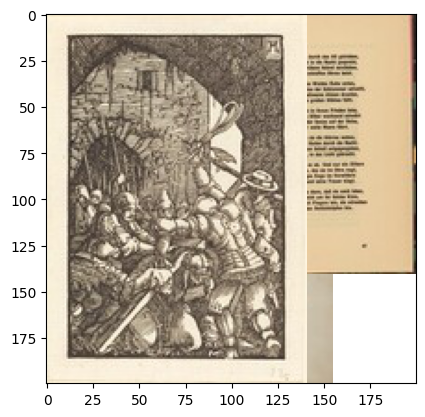

In [13]:
for uuid, url in zip(df_partial['uuid'], df_partial['iiifthumburl']):
  print("Downloading {} image from {}..".format(uuid, url))
  
  img_data = requests.get(url).content
  image_path = "{}.jpg".format(uuid)
  
  with open(image_path, 'wb') as handler:
    handler.write(img_data)
  
  plt.imshow(Image.open(image_path))
  plt.plot()

# Carregamento e normalização das imagens

In [14]:
filenames = os.listdir('.')
filenames = [filename for filename in filenames if filename.endswith('.jpg')]
images = np.empty(shape=(len(filenames), 32, 32, 3))
for i, filename in enumerate(filenames):
  images[i] = np.asarray(Image.open(filename).resize((32, 32))) / 255.0

In [15]:
images.shape

(5, 32, 32, 3)

In [16]:
images.max()

1.0

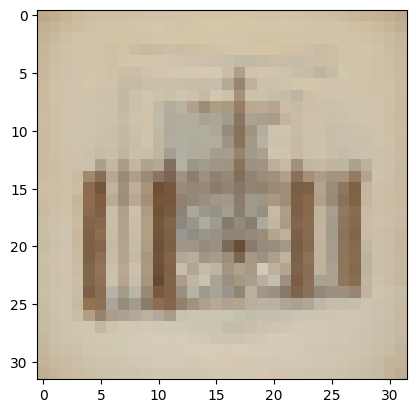

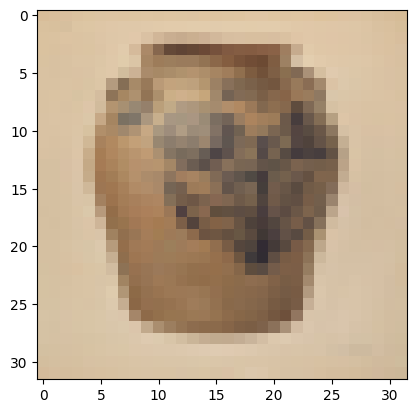

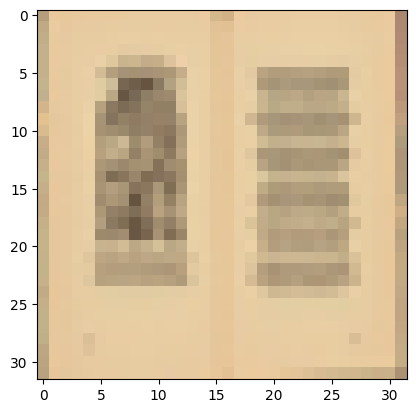

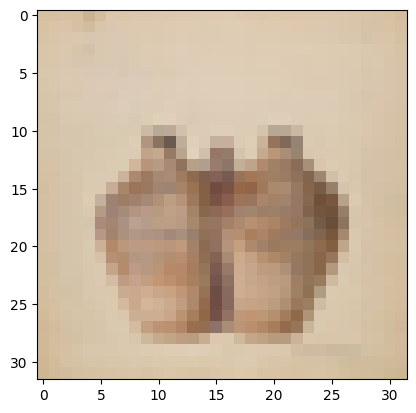

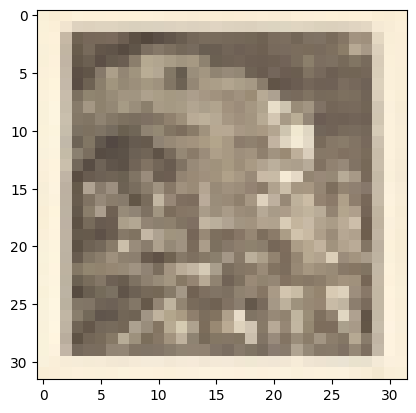

In [17]:
for i in range(len(images)):
  plt.figure(i)
  plt.imshow(images[i])

plt.show()

Uso do arquivo de imagens reduzidas

In [18]:
images = np.load('/content/gdrive/MyDrive/Projetos git/07-Artml_Som/images.cache.npy')

In [19]:
images.shape

(104720, 32, 32, 3)

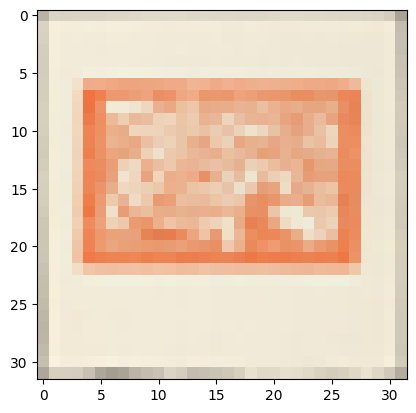

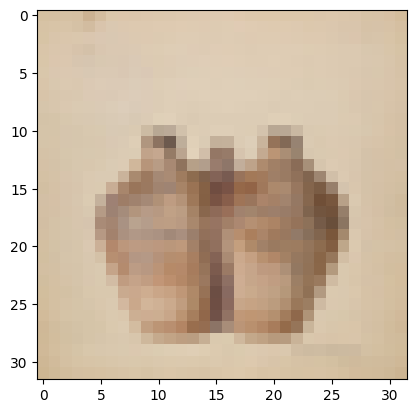

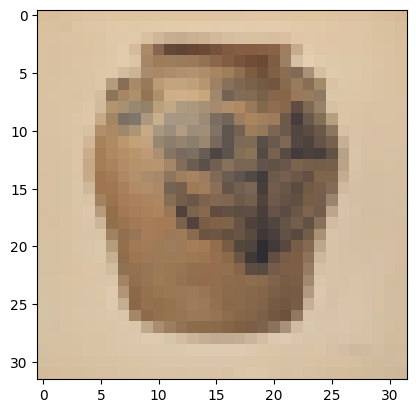

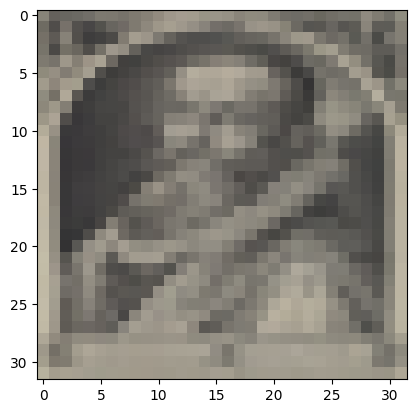

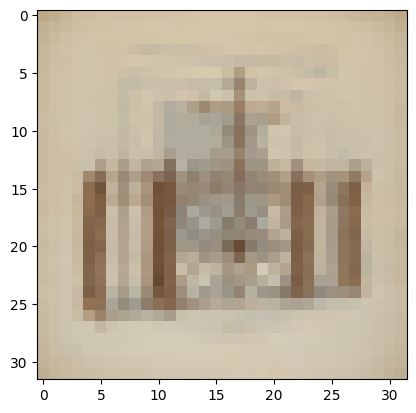

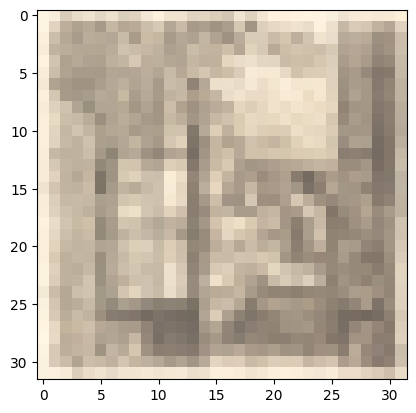

In [20]:
for i in range(6):
  plt.figure(i)
  plt.imshow(images[i])

plt.show()

Split e treinamento

In [21]:
train_x, test_x, train_y, test_y = train_test_split(images, images, test_size=0.3, random_state=SEED)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.3, random_state=SEED)

In [ ]:
train_x.shape

(51312, 32, 32, 3)

# Definição do Autoencoder

In [22]:
def build_autoencoder_callbacks():
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_PATH,
                                                    save_weights_only=True,
                                                    monitor='val_loss',
                                                    mode='min',
                                                    save_best_only=True,
                                                    verbose=True)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                      patience=10)
    return [checkpoint, early_stopping]

In [23]:
def build_encoder():
    input_layer = x = tf.keras.layers.Input(shape=(32, 32, 3))
    for i in range(CONVOLUTIONAL_BLOCKS):
        factor = 2 ** i
        x = tf.keras.layers.Conv2D(BASE_FILTER_SIZE * factor, kernel_size=KERNEL_SIZE, strides=2, padding='SAME')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(COMPRESSION_SIZE, activation='sigmoid')(x)
    return tf.keras.models.Model(inputs=input_layer, outputs=x)

In [24]:
def build_decoder():
    input_factor = 2 ** (CONVOLUTIONAL_BLOCKS - 1)
    input_width = 32 // (input_factor * 2)

    input_layer = x = tf.keras.layers.Input(shape=(COMPRESSION_SIZE,))

    x = tf.keras.layers.Dense(input_width * input_width * BASE_FILTER_SIZE * input_factor, activation='relu')(x)
    x = tf.keras.layers.Reshape(target_shape=(input_width, input_width, BASE_FILTER_SIZE * input_factor))(x)
    for i in range(CONVOLUTIONAL_BLOCKS):
        factor = 2 ** (CONVOLUTIONAL_BLOCKS - i - 1)
        x = tf.keras.layers.Conv2D(BASE_FILTER_SIZE * factor, kernel_size=KERNEL_SIZE, strides=1, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.UpSampling2D()(x)
        x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(3, kernel_size=KERNEL_SIZE, strides=1, padding='SAME', activation='sigmoid')(x)

    return tf.keras.models.Model(inputs=input_layer, outputs=x)

In [25]:
def build_autoencoder():
    encoder = build_encoder()
    decoder = build_decoder()
    autoencoder = tf.keras.models.Sequential([
        encoder,
        decoder
    ])

    autoencoder.compile(
        optimizer='adam',
        loss='mse'
    )

    return encoder, decoder, autoencoder

In [26]:
encoder, decoder, autoencoder = build_autoencoder()

In [27]:
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 12)        588       
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 12)       48        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 16, 16, 12)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 24)          4632      
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 24)         96        
 hNormalization)                                             

In [28]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_1 (Dense)             (None, 768)               25344     
                                                                 
 reshape (Reshape)           (None, 4, 4, 48)          0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 48)          36912     
                                                                 
 batch_normalization_3 (Batc  (None, 4, 4, 48)         192       
 hNormalization)                                                 
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 48)         0         
 )                                                         

# Treinamento do Autoencoder

In [29]:
autoencoder_train_history = autoencoder.fit(train_x, train_y,
                epochs=MAX_EPOCHS, callbacks=build_autoencoder_callbacks(),
                validation_data=(valid_x, valid_y), verbose=True)

Epoch 1/5
1604/1604 [==============================] - ETA: 0s - loss: 0.0132
Epoch 1: val_loss improved from inf to 0.00994, saving model to ./autoencoder.ckpt
1604/1604 [==============================] - 224s 137ms/step - loss: 0.0132 - val_loss: 0.0099
Epoch 2/5
1604/1604 [==============================] - ETA: 0s - loss: 0.0092
Epoch 2: val_loss improved from 0.00994 to 0.00845, saving model to ./autoencoder.ckpt
1604/1604 [==============================] - 228s 142ms/step - loss: 0.0092 - val_loss: 0.0084
Epoch 3/5
1604/1604 [==============================] - ETA: 0s - loss: 0.0084
Epoch 3: val_loss did not improve from 0.00845
1604/1604 [==============================] - 219s 137ms/step - loss: 0.0084 - val_loss: 0.0089
Epoch 4/5
1604/1604 [==============================] - ETA: 0s - loss: 0.0080
Epoch 4: val_loss improved from 0.00845 to 0.00761, saving model to ./autoencoder.ckpt
1604/1604 [==============================] - 219s 137ms/step - loss: 0.0080 - val_loss: 0.0076
Epoc

# Avaliação do Autoencoder

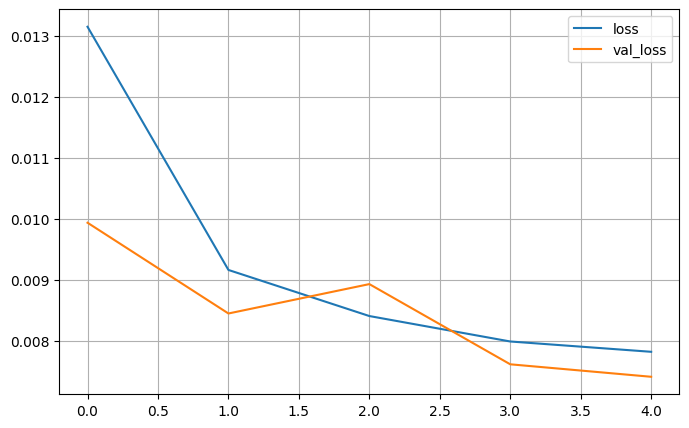

In [30]:
pd.DataFrame(autoencoder_train_history.history).plot(figsize=(8, 5))
plt.gca()
plt.grid(True)

Treino completo: 

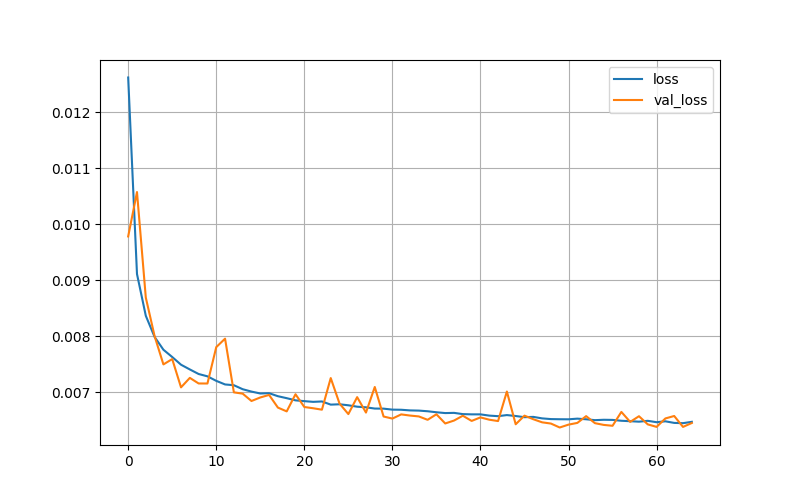

In [31]:
autoencoder.load_weights(PRE_TRAINED_CHECKPOINT_PATH).expect_partial()

NotFoundError: ignored

In [32]:
autoencoder.evaluate(test_x, test_y)

982/982 [==============================] - 38s 38ms/step - loss: 0.0074


0.007380393799394369

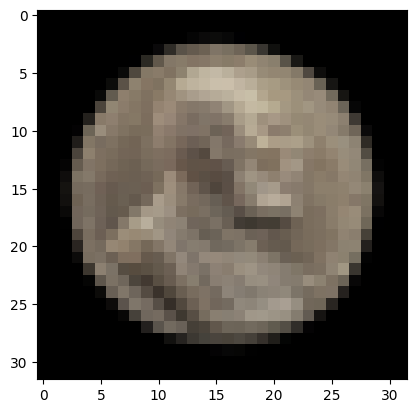

In [33]:
plt.imshow(test_x[7])

1/1 [==============================] - 0s 280ms/step


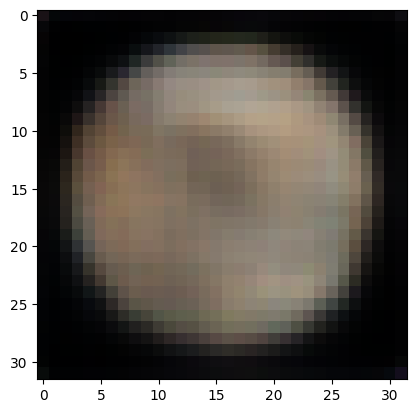

In [34]:
reconstruction = autoencoder.predict(np.array([test_x[7]]))[0]
plt.imshow(reconstruction)

In [35]:
train_encodings = encoder.predict(train_x)

1604/1604 [==============================] - 12s 8ms/step


In [36]:
test_encodings = encoder.predict(test_x)

982/982 [==============================] - 7s 7ms/step


# Mapas Auto-Organizáveis

In [37]:
class Utils:
  @staticmethod
  def euclidean_distance(a, b):
      return (a - b) ** 2

  @staticmethod
  def decay(t, decay_rate, initial_value):
      return initial_value * np.exp(-t * decay_rate)

In [38]:
class SOM:
    def __init__(self, node_count=10, dimensions=4, eta_decay_rate=1e-2, initial_sigma=3.0,
                 sigma_decay_rate=1e-2, min_sigma=0.1,
                 initial_eta=0.1, min_eta=0.01):
        self.nodes = np.random.random_sample(size=(node_count, dimensions))
        self.node_count = node_count

        self.eta_decay_rate = eta_decay_rate
        self.initial_eta = initial_eta

        self.sigma_decay_rate = sigma_decay_rate
        self.initial_sigma = initial_sigma

    def init_from_dataset(self, dataset):
        for i in range(len(self.nodes)):
            self.nodes[i] = dataset[np.random.randint(len(dataset))]

    def gaussian_neighborhood(self, x, step):
        return np.exp(-((x ** 2) / (self.sigma(step) ** 2)))

    def ricker_wavelet(self, x, step):
        a = self.sigma(step)
        y = (2 / (np.sqrt(3 * a) * np.power(np.pi, 1 / 3)))\
            * (1 - (x / a) ** 2) * np.exp(-(x ** 2) / (a ** 2))

        y[y > 1.0] = 1.0
        return y

    def topological_neighborhood(self, distances, step):
      return self.ricker_wavelet(distances, step)

    def sigma(self, step):
        return Utils.decay(step, self.sigma_decay_rate, self.initial_sigma)

    def eta(self, step):
        return Utils.decay(step, self.eta_decay_rate, self.initial_eta)

    def predict(self, point):
        return Utils.euclidean_distance(self.nodes, point).sum(axis=1).argmin()

    def fit(self, dataset, steps=1):
        for step in range(steps):
            sample = dataset[step % len(dataset)]
            winner = self.predict(sample)

            distance_from_winner = Utils.euclidean_distance(self.nodes,
                                                            self.nodes[winner])
            
            topological_neighborhood = self.topological_neighborhood(distance_from_winner, step)
            for i in range(len(self.nodes)):
              self.nodes[i] += self.eta(step) * topological_neighborhood[i] * (sample - self.nodes[i])

In [39]:
som = SOM(node_count=NODE_COUNT, dimensions=COMPRESSION_SIZE,
          initial_sigma=INITIAL_SIGMA, sigma_decay_rate=SIGMA_DECAY_RATE,
          initial_eta=INITIAL_ETA, eta_decay_rate=ETA_DECAY_RATE)

In [40]:
som.fit(train_encodings, STEP_COUNT)

In [41]:
def plot_grid(images, width, height):
    _, axs = plt.subplots(width, height, figsize=(12, 12))
    axs = axs.flatten()
    for img, ax in zip(images, axs):
        ax.imshow(img)

    plt.show()

In [42]:
som_predictions = [som.predict(encoding) for encoding in test_encodings]

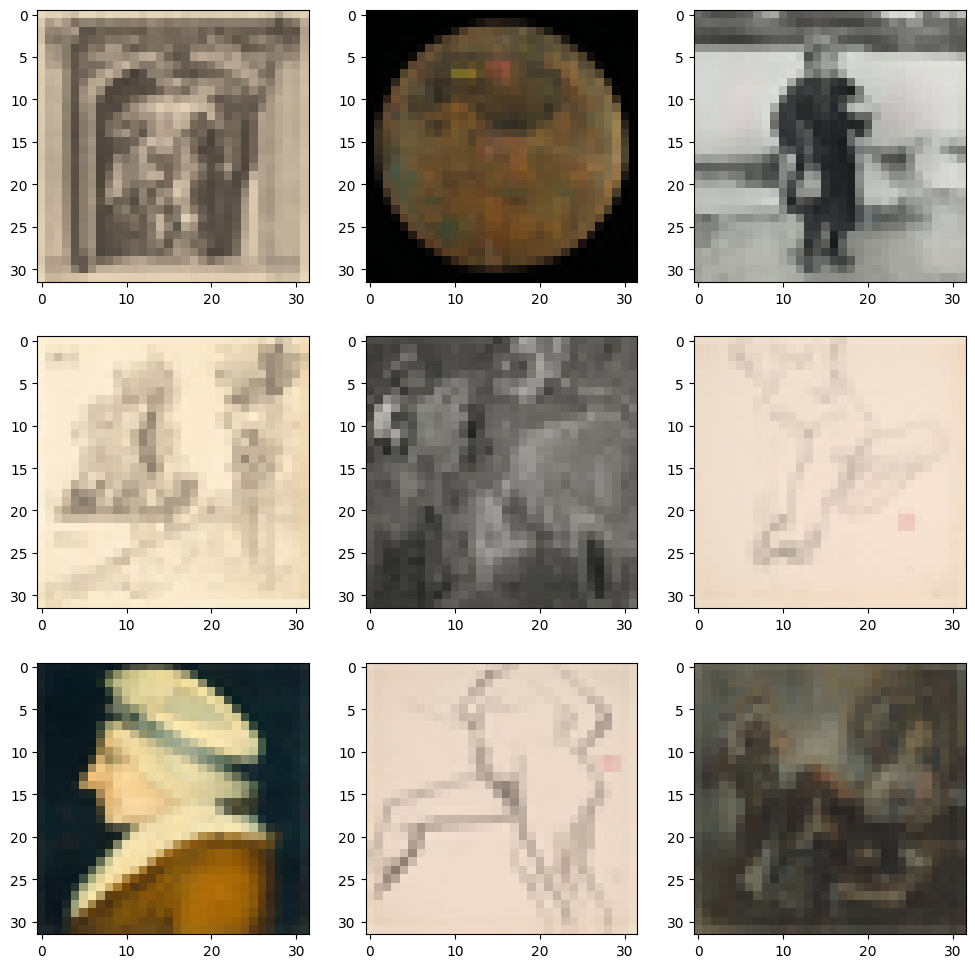

In [43]:
image_indexes = [i for i, pred in enumerate(som_predictions) if pred == 2]
plot_grid([train_x[i] for i in image_indexes], 3, 3)

# Busca por imagens similares

Escolhemos uma imagem aleatoriano caso index 7 e  vamos buscar 25 imagens mais próximas desse alvo, da mesma classe

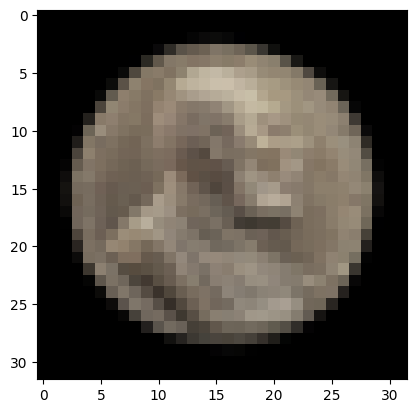

In [44]:
target_index =7
target = test_x[target_index]
target_encodings = test_encodings[target_index]

plt.imshow(target)
plt.show()

In [45]:
distances_from_target = ((train_encodings - target_encodings) ** 2).sum(axis=1)
distances_from_target = list(enumerate(distances_from_target))
distances_from_target = sorted(distances_from_target, key=lambda p:p[1])

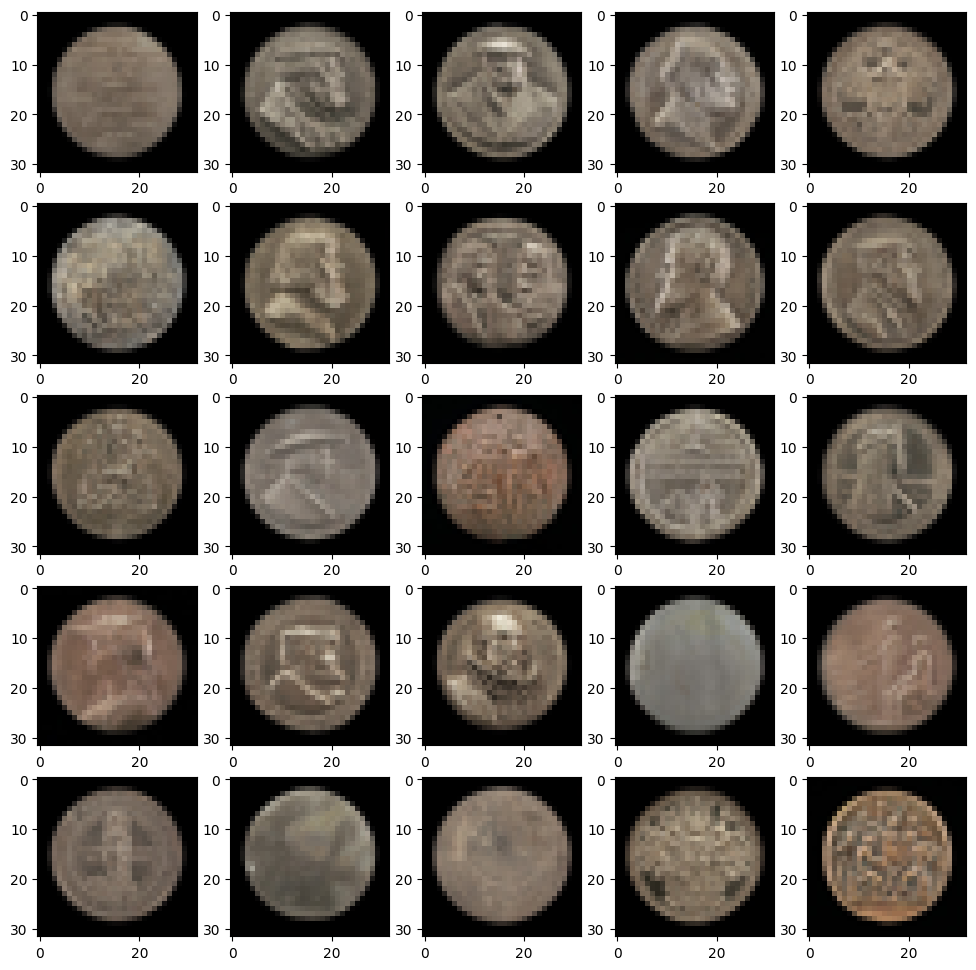

In [46]:
nearest_images = [train_x[i] for i, _ in distances_from_target[:25]]
plot_grid(nearest_images, 5, 5)